⚙️ Début du Feature Engineering

📁 Chargement des données preprocessées...
✅ Dataset unifié chargé: 58 incidents

📊 Aperçu des données:
  - Nombre d'incidents: 58
  - Période: 2015-05-13 09:43:12 à 2025-04-29 01:13:01
  - Types de sources: 2
  - Répartition par gravité:
    * MEDIUM: 37 (63.8%)
    * LOW: 13 (22.4%)
    * HIGH: 8 (13.8%)

🗺️ CRÉATION DES FEATURES SPATIALES

🔲 Création d'une grille spatiale (taille: 0.005°)...
   ✅ Grille créée: 50 cellules

📊 Calcul des features de densité...
   ✅ Features de densité créées pour 50 zones
   📈 Statistiques de densité:
      - Incidents par zone: 1.2 ± 0.5
      - Zone la plus active: 4 incidents
      - Ratio haute gravité moyen: 0.16

📍 Calcul des features de proximité...
   ✅ Distance à downtown: 4388m ± 3102m
   ✅ Distance à harvard_square: 6733m ± 2739m
   ✅ Distance à south_station: 4246m ± 3079m
   ✅ Distance à logan_airport: 7293m ± 3374m

⏰ CRÉATION DES FEATURES TEMPORELLES

🕐 Extraction des features temporelles...
   ✅ Features

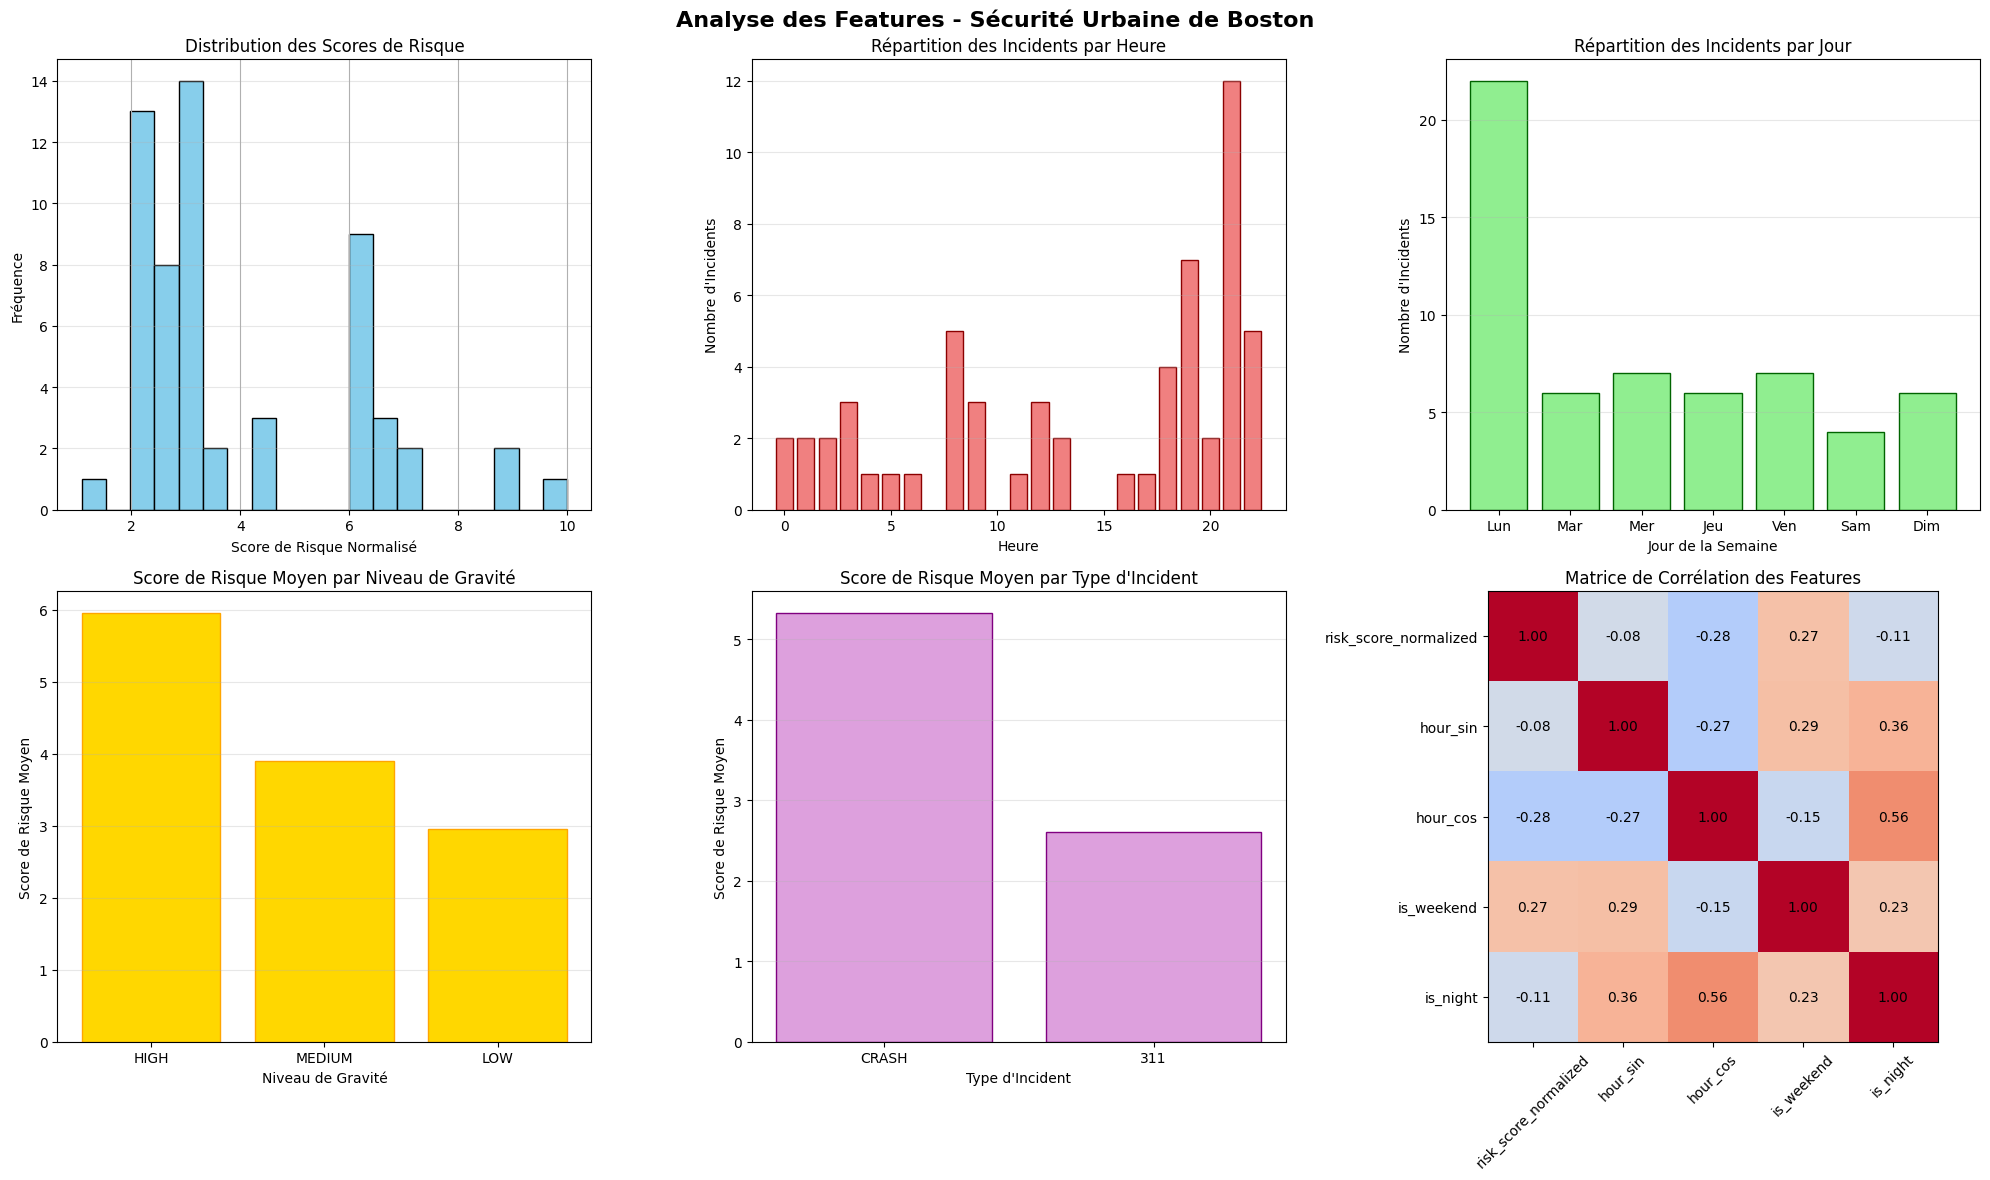

   ✅ Visualisations créées

💾 SAUVEGARDE DES FEATURES ENGINEERED

📋 RÉSUMÉ DU FEATURE ENGINEERING

🚀 PROCHAINE ÉTAPE:
  Les features sont prêtes pour l'entraînement du modèle!
  Prochain notebook: 04_model_development.ipynb

✨ FEATURE ENGINEERING TERMINÉ AVEC SUCCÈS


In [4]:
# Feature Engineering - Modèle de Prédiction de Rues Risquées

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

# Librairies géospatiales
from math import radians, cos, sin, asin, sqrt, atan2, pi
import folium
from folium.plugins import HeatMap

print("⚙️ Début du Feature Engineering")
print("="*60)

# =====================================================================
# 1. CHARGEMENT DES DONNÉES PREPROCESSING
# =====================================================================

print("\n📁 Chargement des données preprocessées...")

def load_processed_data():
    """Charge les données preprocessées"""
    try:
        # Essayer de charger le dataset unifié
        df_unified = pd.read_parquet('../data/processed/unified_incidents.parquet')
        print(f"✅ Dataset unifié chargé: {len(df_unified):,} incidents")
        return df_unified
    except FileNotFoundError:
        try:
            df_unified = pd.read_csv('../data/processed/unified_incidents.csv')
            print(f"✅ Dataset unifié chargé (CSV): {len(df_unified):,} incidents")
            return df_unified
        except FileNotFoundError:
            print("❌ Fichier unified_incidents non trouvé")
            return None
    except Exception as e:
        print(f"❌ Erreur chargement: {e}")
        return None

# Chargement des données
df_incidents = load_processed_data()

if df_incidents is not None:
    # Conversion des dates si nécessaire
    if 'incident_datetime' in df_incidents.columns:
        df_incidents['incident_datetime'] = pd.to_datetime(df_incidents['incident_datetime'])
    
    print(f"\n📊 Aperçu des données:")
    print(f"  - Nombre d'incidents: {len(df_incidents):,}")
    print(f"  - Période: {df_incidents['incident_datetime'].min()} à {df_incidents['incident_datetime'].max()}")
    print(f"  - Types de sources: {df_incidents['data_source'].nunique()}")
    print(f"  - Répartition par gravité:")
    for severity, count in df_incidents['severity'].value_counts().items():
        print(f"    * {severity}: {count:,} ({count/len(df_incidents)*100:.1f}%)")

# =====================================================================
# 2. CRÉATION DES FEATURES SPATIALES
# =====================================================================

print("\n" + "="*60)
print("🗺️ CRÉATION DES FEATURES SPATIALES")
print("="*60)

def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calcule la distance en mètres entre deux points géographiques.
    Utilise la formule de Haversine.
    """
    # Conversion en radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Difference
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    
    # Formule de Haversine
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    
    # Rayon de la Terre en mètres
    earth_radius = 6371000
    
    return c * earth_radius

def create_spatial_grid(df, grid_size=0.005):
    """
    Crée une grille spatiale pour agréger les incidents.
    
    Args:
        df: DataFrame avec colonnes latitude/longitude
        grid_size: Taille de grille en degrés (défaut: ~500m)
    
    Returns:
        DataFrame avec colonnes de grille ajoutées
    """
    print(f"\n🔲 Création d'une grille spatiale (taille: {grid_size}°)...")
    
    # Calcul des limites
    lat_min, lat_max = df['latitude'].min(), df['latitude'].max()
    lon_min, lon_max = df['longitude'].min(), df['longitude'].max()
    
    # Création des bins de grille
    lat_bins = np.arange(lat_min - grid_size, lat_max + grid_size, grid_size)
    lon_bins = np.arange(lon_min - grid_size, lon_max + grid_size, grid_size)
    
    # Attribution des cellules de grille
    df_spatial = df.copy()
    df_spatial['grid_lat'] = pd.cut(df_spatial['latitude'], lat_bins, include_lowest=True)
    df_spatial['grid_lon'] = pd.cut(df_spatial['longitude'], lon_bins, include_lowest=True)
    
    # Coordonnées du centre de cellule
    df_spatial['grid_lat_center'] = df_spatial['grid_lat'].apply(lambda x: x.mid if pd.notna(x) else None)
    df_spatial['grid_lon_center'] = df_spatial['grid_lon'].apply(lambda x: x.mid if pd.notna(x) else None)
    
    # ID unique de grille
    df_spatial['grid_id'] = df_spatial['grid_lat'].astype(str) + '_' + df_spatial['grid_lon'].astype(str)
    
    print(f"   ✅ Grille créée: {df_spatial['grid_id'].nunique()} cellules")
    
    return df_spatial

def calculate_density_features(df):
    """
    Calcule les features de densité d'incidents par zone.
    """
    print(f"\n📊 Calcul des features de densité...")
    
    # Agrégation par cellule de grille - approche simplifiée
    grid_stats = df.groupby('grid_id').agg({
        'latitude': 'first',
        'longitude': 'first',
        'grid_lat_center': 'first',
        'grid_lon_center': 'first',
        'incident_datetime': 'count',  # Simplicifié pour éviter les multi-level columns
        'severity': lambda x: (x == 'HIGH').sum(),
        'data_source': 'nunique',
        'incident_type': lambda x: x.mode().iloc[0] if len(x) > 0 else 'UNKNOWN'
    }).reset_index()
    
    # Renommage des colonnes pour clarifier
    grid_stats = grid_stats.rename(columns={
        'latitude': 'sample_lat',
        'longitude': 'sample_lon', 
        'incident_datetime': 'incident_count',
        'severity': 'high_severity_count',
        'data_source': 'source_diversity',
        'incident_type': 'dominant_type'
    })
    
    # Calcul des dates min/max séparément pour éviter les problèmes multi-level
    date_stats = df.groupby('grid_id')['incident_datetime'].agg(['min', 'max']).reset_index()
    date_stats.columns = ['grid_id', 'first_incident', 'last_incident']
    
    # Jointure des stats de date
    grid_stats = grid_stats.merge(date_stats, on='grid_id', how='left')
    
    # Calcul de features dérivées
    grid_stats['incident_density'] = grid_stats['incident_count']
    grid_stats['high_severity_ratio'] = grid_stats['high_severity_count'] / grid_stats['incident_count']
    grid_stats['days_span'] = (grid_stats['last_incident'] - grid_stats['first_incident']).dt.days + 1
    grid_stats['incident_frequency'] = grid_stats['incident_count'] / grid_stats['days_span']
    
    print(f"   ✅ Features de densité créées pour {len(grid_stats)} zones")
    print(f"   📈 Statistiques de densité:")
    print(f"      - Incidents par zone: {grid_stats['incident_count'].mean():.1f} ± {grid_stats['incident_count'].std():.1f}")
    print(f"      - Zone la plus active: {grid_stats['incident_count'].max()} incidents")
    print(f"      - Ratio haute gravité moyen: {grid_stats['high_severity_ratio'].mean():.2f}")
    
    return grid_stats

def calculate_proximity_features(df, poi_coords):
    """
    Calcule les features de proximité à des points d'intérêt.
    
    Args:
        df: DataFrame des incidents
        poi_coords: Dict des points d'intérêt {nom: (lat, lon)}
    """
    print(f"\n📍 Calcul des features de proximité...")
    
    df_proximity = df.copy()
    
    for poi_name, (poi_lat, poi_lon) in poi_coords.items():
        # Calcul de distance à chaque POI
        distances = df_proximity.apply(
            lambda row: calculate_distance(row['latitude'], row['longitude'], poi_lat, poi_lon),
            axis=1
        )
        df_proximity[f'distance_to_{poi_name}'] = distances
        df_proximity[f'near_{poi_name}'] = (distances < 500).astype(int)  # Dans les 500m
        
        print(f"   ✅ Distance à {poi_name}: {distances.mean():.0f}m ± {distances.std():.0f}m")
    
    return df_proximity

# Application des features spatiales
if df_incidents is not None:
    # Création de la grille spatiale
    df_spatial = create_spatial_grid(df_incidents, grid_size=0.005)
    
    # Calcul des features de densité
    grid_stats = calculate_density_features(df_spatial)
    
    # Points d'intérêt pour Boston (exemples approximatifs)
    boston_pois = {
        'downtown': (42.3581, -71.0636),
        'harvard_square': (42.3743, -71.1201),
        'south_station': (42.3518, -71.0552),
        'logan_airport': (42.3656, -71.0096)
    }
    
    # Calcul des proximités (sur l'échantillon pour performance)
    df_proximity = calculate_proximity_features(df_spatial, boston_pois)

# =====================================================================
# 3. CRÉATION DES FEATURES TEMPORELLES
# =====================================================================

print("\n" + "="*60)
print("⏰ CRÉATION DES FEATURES TEMPORELLES")
print("="*60)

def extract_temporal_features(df):
    """
    Extrait des features temporelles détaillées.
    """
    print(f"\n🕐 Extraction des features temporelles...")
    
    df_temporal = df.copy()
    
    # Features temporelles de base (déjà présentes mais on les recalcule pour s'assurer)
    df_temporal['year'] = df_temporal['incident_datetime'].dt.year
    df_temporal['month'] = df_temporal['incident_datetime'].dt.month
    df_temporal['day'] = df_temporal['incident_datetime'].dt.day
    df_temporal['weekday'] = df_temporal['incident_datetime'].dt.dayofweek
    df_temporal['hour'] = df_temporal['incident_datetime'].dt.hour
    df_temporal['day_of_year'] = df_temporal['incident_datetime'].dt.dayofyear
    df_temporal['week_of_year'] = df_temporal['incident_datetime'].dt.isocalendar().week
    
    # Features cycliques (pour capturer la nature cyclique du temps)
    df_temporal['hour_sin'] = np.sin(2 * np.pi * df_temporal['hour'] / 24)
    df_temporal['hour_cos'] = np.cos(2 * np.pi * df_temporal['hour'] / 24)
    df_temporal['day_sin'] = np.sin(2 * np.pi * df_temporal['weekday'] / 7)
    df_temporal['day_cos'] = np.cos(2 * np.pi * df_temporal['weekday'] / 7)
    df_temporal['month_sin'] = np.sin(2 * np.pi * df_temporal['month'] / 12)
    df_temporal['month_cos'] = np.cos(2 * np.pi * df_temporal['month'] / 12)
    
    # Classifications temporelles
    df_temporal['is_weekend'] = (df_temporal['weekday'] >= 5).astype(int)
    df_temporal['is_rush_hour'] = ((df_temporal['hour'].between(7, 9)) | 
                                   (df_temporal['hour'].between(17, 19))).astype(int)
    df_temporal['is_night'] = ((df_temporal['hour'] >= 22) | 
                              (df_temporal['hour'] <= 5)).astype(int)
    df_temporal['is_business_hours'] = (df_temporal['hour'].between(9, 17) & 
                                       (df_temporal['weekday'] < 5)).astype(int)
    
    # Saisons (approximatives pour l'hémisphère Nord)
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    
    df_temporal['season'] = df_temporal['month'].apply(get_season)
    
    print(f"   ✅ Features temporelles créées:")
    print(f"      - Répartition week-end vs semaine: {df_temporal['is_weekend'].mean():.1%} weekend")
    print(f"      - Incidents pendant heures de pointe: {df_temporal['is_rush_hour'].mean():.1%}")
    print(f"      - Incidents nocturnes: {df_temporal['is_night'].mean():.1%}")
    print(f"      - Incidents heures bureau: {df_temporal['is_business_hours'].mean():.1%}")
    
    return df_temporal

def calculate_temporal_aggregates(df):
    """
    Calcule des agrégations temporelles pour détecter les patterns.
    """
    print(f"\n📈 Calcul des agrégations temporelles...")
    
    # Agrégation par heure
    hourly_stats = df.groupby('hour').agg({
        'incident_datetime': 'count',
        'severity': lambda x: (x == 'HIGH').sum()
    }).rename(columns={'incident_datetime': 'incidents_per_hour'})
    hourly_stats['high_severity_per_hour'] = hourly_stats['severity']
    hourly_stats = hourly_stats.drop('severity', axis=1)
    
    # Agrégation par jour de la semaine
    daily_stats = df.groupby('weekday').agg({
        'incident_datetime': 'count',
        'severity': lambda x: (x == 'HIGH').sum()
    }).rename(columns={'incident_datetime': 'incidents_per_weekday'})
    daily_stats['high_severity_per_weekday'] = daily_stats['severity']
    daily_stats = daily_stats.drop('severity', axis=1)
    
    # Agrégation par mois
    monthly_stats = df.groupby('month').agg({
        'incident_datetime': 'count',
        'severity': lambda x: (x == 'HIGH').sum()
    }).rename(columns={'incident_datetime': 'incidents_per_month'})
    monthly_stats['high_severity_per_month'] = monthly_stats['severity']
    monthly_stats = monthly_stats.drop('severity', axis=1)
    
    # Jointure avec le DataFrame principal
    df_enriched = df.copy()
    df_enriched = df_enriched.merge(hourly_stats, left_on='hour', right_index=True, how='left')
    df_enriched = df_enriched.merge(daily_stats, left_on='weekday', right_index=True, how='left')
    df_enriched = df_enriched.merge(monthly_stats, left_on='month', right_index=True, how='left')
    
    print(f"   ✅ Agrégations temporelles ajoutées")
    
    return df_enriched

# Application des features temporelles
if df_incidents is not None:
    df_temporal = extract_temporal_features(df_incidents)
    df_temporal_enriched = calculate_temporal_aggregates(df_temporal)

# =====================================================================
# 4. CRÉATION DU SCORE DE RISQUE COMPOSITE
# =====================================================================

print("\n" + "="*60)
print("⚖️ CRÉATION DU SCORE DE RISQUE COMPOSITE")
print("="*60)

def calculate_severity_weights():
    """
    Définit les poids pour chaque niveau de gravité et type d'incident.
    """
    
    # Poids par niveau de gravité
    severity_weights = {
        'HIGH': 3.0,
        'MEDIUM': 2.0,
        'LOW': 1.0
    }
    
    # Poids par type d'incident
    incident_type_weights = {
        'CRIME': 3.0,      # Crimes sont les plus critiques
        'CRASH': 2.5,      # Accidents de la route
        '311': 1.5         # Rapports de service
    }
    
    # Poids par source de données
    source_weights = {
        'CRIME_INCIDENTS': 3.0,
        'TRAFFIC_CRASHES': 2.5,
        '311_REPORTS': 1.5
    }
    
    return severity_weights, incident_type_weights, source_weights

def calculate_risk_score(df):
    """
    Calcule un score de risque composite pour chaque incident.
    """
    print(f"\n🎯 Calcul du score de risque composite...")
    
    severity_weights, incident_type_weights, source_weights = calculate_severity_weights()
    
    df_risk = df.copy()
    
    # Score de base selon la gravité
    df_risk['severity_score'] = df_risk['severity'].map(severity_weights).fillna(1.0)
    
    # Score selon le type d'incident
    df_risk['type_score'] = df_risk['incident_type'].map(incident_type_weights).fillna(1.0)
    
    # Score selon la source
    df_risk['source_score'] = df_risk['data_source'].map(source_weights).fillna(1.0)
    
    # Facteurs temporels (incidents nocturnes et week-end sont plus préoccupants)
    df_risk['temporal_multiplier'] = 1.0
    df_risk.loc[df_risk['is_night'] == 1, 'temporal_multiplier'] *= 1.2
    df_risk.loc[df_risk['is_weekend'] == 1, 'temporal_multiplier'] *= 1.1
    
    # Score de risque composite final
    df_risk['risk_score'] = (
        df_risk['severity_score'] * 
        df_risk['type_score'] * 
        df_risk['source_score'] * 
        df_risk['temporal_multiplier']
    )
    
    # Normalisation du score de risque (0-10)
    max_score = df_risk['risk_score'].max()
    df_risk['risk_score_normalized'] = (df_risk['risk_score'] / max_score) * 10
    
    # Classification en catégories de risque
    def classify_risk_level(score):
        if score >= 7:
            return 'VERY_HIGH'
        elif score >= 5:
            return 'HIGH'
        elif score >= 3:
            return 'MEDIUM'
        else:
            return 'LOW'
    
    df_risk['risk_level'] = df_risk['risk_score_normalized'].apply(classify_risk_level)
    
    print(f"   ✅ Score de risque calculé:")
    print(f"      - Score moyen: {df_risk['risk_score_normalized'].mean():.2f}")
    print(f"      - Score max: {df_risk['risk_score_normalized'].max():.2f}")
    print(f"      - Répartition par niveau de risque:")
    for level, count in df_risk['risk_level'].value_counts().items():
        print(f"        * {level}: {count:,} ({count/len(df_risk)*100:.1f}%)")
    
    return df_risk

def calculate_grid_risk_scores(df_incidents, grid_stats):
    """
    Calcule les scores de risque agrégés par cellule de grille.
    """
    print(f"\n📍 Calcul des scores de risque par zone...")
    
    # Agrégation des scores par grille - éviter les conflits de noms
    grid_risk = df_incidents.groupby('grid_id').agg({
        'risk_score_normalized': ['mean', 'max', 'sum'],
        'risk_level': lambda x: x.mode().iloc[0] if len(x) > 0 else 'LOW'
    }).reset_index()
    
    # Aplatissement des colonnes multi-level
    grid_risk.columns = [
        'grid_id', 'avg_risk_score', 'max_risk_score', 'total_risk_score',
        'dominant_risk_level'
    ]
    
    # Comptage séparé pour éviter les conflits de nom
    incident_counts = df_incidents.groupby('grid_id').size().reset_index(name='risk_incident_count')
    grid_risk = grid_risk.merge(incident_counts, on='grid_id', how='left')
    
    # Jointure avec les stats de grille
    grid_risk_combined = grid_stats.merge(grid_risk, on='grid_id', how='left')
    
    # Gestion des valeurs manquantes après jointure
    grid_risk_combined['avg_risk_score'] = grid_risk_combined['avg_risk_score'].fillna(0)
    grid_risk_combined['max_risk_score'] = grid_risk_combined['max_risk_score'].fillna(0)
    grid_risk_combined['total_risk_score'] = grid_risk_combined['total_risk_score'].fillna(0)
    grid_risk_combined['risk_incident_count'] = grid_risk_combined['risk_incident_count'].fillna(0)
    grid_risk_combined['dominant_risk_level'] = grid_risk_combined['dominant_risk_level'].fillna('LOW')
    
    # Score de risque composite par zone (pondéré par la fréquence)
    # Utiliser risk_incident_count au lieu d'incident_count pour éviter la confusion
    grid_risk_combined['zone_risk_score'] = (
        grid_risk_combined['avg_risk_score'] * 
        np.log1p(grid_risk_combined['risk_incident_count']) *  # Log pour éviter les valeurs extrêmes
        (1 + grid_risk_combined['high_severity_ratio'])   # Bonus pour haute gravité
    )
    
    # Normalisation du score de zone (0-10)
    max_zone_score = grid_risk_combined['zone_risk_score'].max()
    if max_zone_score > 0:
        grid_risk_combined['zone_risk_score_normalized'] = (
            grid_risk_combined['zone_risk_score'] / max_zone_score
        ) * 10
    else:
        grid_risk_combined['zone_risk_score_normalized'] = 0
    
    # Classification des zones
    def classify_zone_risk(score):
        if pd.isna(score):
            return 'UNKNOWN'
        elif score >= 8:
            return 'CRITICAL'
        elif score >= 6:
            return 'HIGH'
        elif score >= 4:
            return 'MEDIUM'
        elif score >= 2:
            return 'LOW'
        else:
            return 'MINIMAL'
    
    grid_risk_combined['zone_risk_category'] = grid_risk_combined['zone_risk_score_normalized'].apply(classify_zone_risk)
    
    print(f"   ✅ Scores de risque par zone calculés:")
    print(f"      - Score moyen par zone: {grid_risk_combined['zone_risk_score_normalized'].mean():.2f}")
    print(f"      - Zones critiques: {(grid_risk_combined['zone_risk_category'] == 'CRITICAL').sum()}")
    print(f"      - Zones à risque élevé: {(grid_risk_combined['zone_risk_category'] == 'HIGH').sum()}")
    
    return grid_risk_combined

# Application du score de risque
if df_incidents is not None:
    df_risk = calculate_risk_score(df_temporal_enriched)
    
    # Ajout du grid_id au DataFrame des incidents s'il n'existe pas déjà
    if 'grid_id' not in df_risk.columns and 'df_spatial' in locals():
        df_risk = df_risk.merge(
            df_spatial[['latitude', 'longitude', 'grid_id']], 
            on=['latitude', 'longitude'], 
            how='left'
        )
    
    # Calcul des scores par zone
    if 'grid_stats' in locals():
        grid_risk_scores = calculate_grid_risk_scores(df_risk, grid_stats)

# =====================================================================
# 5. DÉTECTION DE CLUSTERS D'INCIDENTS
# =====================================================================

print("\n" + "="*60)
print("🔍 DÉTECTION DE CLUSTERS D'INCIDENTS")
print("="*60)

def detect_incident_clusters(df, eps=0.01, min_samples=2):
    """
    Détecte les clusters d'incidents à l'aide de DBSCAN.
    
    Args:
        df: DataFrame avec latitude et longitude
        eps: Distance maximum entre points (en degrés, ~1km = 0.01°)
        min_samples: Nombre minimum de points par cluster
    """
    print(f"\n🔬 Détection de clusters avec DBSCAN...")
    print(f"   - Paramètres: eps={eps}° (~{eps*111:.0f}km), min_samples={min_samples}")
    
    # Préparation des données pour clustering
    coords = df[['latitude', 'longitude']].values
    
    # Application de DBSCAN
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(coords)
    
    # Ajout des labels au DataFrame
    df_clustered = df.copy()
    df_clustered['cluster_id'] = cluster_labels
    df_clustered['is_in_cluster'] = (cluster_labels != -1).astype(int)
    
    # Statistiques des clusters
    n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    n_noise = list(cluster_labels).count(-1)
    
    print(f"   ✅ Clustering terminé:")
    print(f"      - Nombre de clusters: {n_clusters}")
    print(f"      - Points en clusters: {len(df_clustered) - n_noise} ({(len(df_clustered) - n_noise)/len(df_clustered)*100:.1f}%)")
    print(f"      - Points isolés: {n_noise} ({n_noise/len(df_clustered)*100:.1f}%)")
    
    # Analyse des clusters
    if n_clusters > 0:
        cluster_stats = df_clustered[df_clustered['cluster_id'] != -1].groupby('cluster_id').agg({
            'latitude': ['mean', 'count'],
            'longitude': 'mean',
            'risk_score_normalized': 'mean',
            'severity': lambda x: (x == 'HIGH').sum(),
            'incident_type': lambda x: x.mode().iloc[0] if len(x) > 0 else 'UNKNOWN'
        }).reset_index()
        
        # Aplatissement des colonnes
        cluster_stats.columns = [
            'cluster_id', 'center_lat', 'size', 'center_lon', 
            'avg_risk_score', 'high_severity_count', 'dominant_type'
        ]
        
        print(f"\n   📊 Top 5 clusters par taille:")
        top_clusters = cluster_stats.nlargest(5, 'size')
        for _, cluster in top_clusters.iterrows():
            print(f"      - Cluster {int(cluster['cluster_id'])}: {int(cluster['size'])} incidents")
            print(f"        Centre: ({cluster['center_lat']:.4f}, {cluster['center_lon']:.4f})")
            print(f"        Risque moyen: {cluster['avg_risk_score']:.2f}")
            print(f"        Type dominant: {cluster['dominant_type']}")
    
    return df_clustered, cluster_stats if n_clusters > 0 else None

# Application de la détection de clusters
if df_incidents is not None and 'df_risk' in locals():
    df_clustered, cluster_stats = detect_incident_clusters(df_risk, eps=0.005, min_samples=2)

# =====================================================================
# 6. CRÉATION DES FEATURES FINALES POUR LE MODÈLE
# =====================================================================

print("\n" + "="*60)
print("🎯 CRÉATION DES FEATURES FINALES")
print("="*60)

def create_final_feature_set(df):
    """
    Crée l'ensemble final de features pour l'entraînement du modèle.
    """
    print(f"\n🛠️ Création du jeu de features final...")
    
    # Sélection des features numériques
    numeric_features = [
        # Coordonnées
        'latitude', 'longitude',
        
        # Features temporelles cycliques
        'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos',
        
        # Features temporelles binaires
        'is_weekend', 'is_rush_hour', 'is_night', 'is_business_hours',
        
        # Features d'agrégation temporelle
        'incidents_per_hour', 'incidents_per_weekday', 'incidents_per_month',
        'high_severity_per_hour', 'high_severity_per_weekday', 'high_severity_per_month',
        
        # Score de risque
        'risk_score_normalized',
        
        # Features de clustering
        'is_in_cluster'
    ]
    
    # Features de proximité (si disponibles)
    proximity_features = [col for col in df.columns if col.startswith('distance_to_') or col.startswith('near_')]
    numeric_features.extend(proximity_features)
    
    # Sélection des features catégorielles
    categorical_features = ['severity', 'incident_type', 'data_source', 'season']
    
    # Création du DataFrame final
    available_numeric = [f for f in numeric_features if f in df.columns]
    available_categorical = [f for f in categorical_features if f in df.columns]
    
    print(f"   ✅ Features sélectionnées:")
    print(f"      - Features numériques: {len(available_numeric)}")
    print(f"      - Features catégorielles: {len(available_categorical)}")
    
    # DataFrame avec features sélectionnées
    feature_df = df[available_numeric + available_categorical].copy()
    
    # Encodage des variables catégorielles
    label_encoders = {}
    for cat_feature in available_categorical:
        le = LabelEncoder()
        feature_df[f'{cat_feature}_encoded'] = le.fit_transform(feature_df[cat_feature].astype(str))
        label_encoders[cat_feature] = le
    
    # Features finales (numériques + encodées)
    final_features = available_numeric + [f'{cat}_encoded' for cat in available_categorical]
    
    # Gestion des valeurs manquantes
    feature_df[final_features] = feature_df[final_features].fillna(0)
    
    print(f"   ✅ Dataset final:")
    print(f"      - Nombre d'observations: {len(feature_df)}")
    print(f"      - Nombre de features: {len(final_features)}")
    print(f"      - Valeurs manquantes: {feature_df[final_features].isnull().sum().sum()}")
    
    return feature_df[final_features], label_encoders, final_features

# Application de la création des features finales
if 'df_clustered' in locals():
    X_features, label_encoders, feature_names = create_final_feature_set(df_clustered)
    y_target = df_clustered['risk_score_normalized']  # Variable cible pour régression

# =====================================================================
# 7. VISUALISATION DES FEATURES
# =====================================================================

print("\n" + "="*60)
print("📊 VISUALISATION DES FEATURES")
print("="*60)

def create_feature_visualizations(df, X_features):
    """
    Crée des visualisations pour analyser les features.
    """
    print(f"\n📈 Création des visualisations...")
    
    # Configuration de la figure
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Analyse des Features - Sécurité Urbaine de Boston', fontsize=16, fontweight='bold')
    
    # 1. Distribution des scores de risque
    ax1 = axes[0, 0]
    df['risk_score_normalized'].hist(bins=20, ax=ax1, color='skyblue', edgecolor='black')
    ax1.set_title('Distribution des Scores de Risque')
    ax1.set_xlabel('Score de Risque Normalisé')
    ax1.set_ylabel('Fréquence')
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Incidents par heure
    ax2 = axes[0, 1]
    hourly_counts = df.groupby('hour')['incident_datetime'].count()
    ax2.bar(hourly_counts.index, hourly_counts.values, color='lightcoral', edgecolor='darkred')
    ax2.set_title('Répartition des Incidents par Heure')
    ax2.set_xlabel('Heure')
    ax2.set_ylabel('Nombre d\'Incidents')
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Incidents par jour de la semaine
    ax3 = axes[0, 2]
    days = ['Lun', 'Mar', 'Mer', 'Jeu', 'Ven', 'Sam', 'Dim']
    daily_counts = df.groupby('weekday')['incident_datetime'].count()
    ax3.bar(range(7), daily_counts.values, color='lightgreen', edgecolor='darkgreen')
    ax3.set_title('Répartition des Incidents par Jour')
    ax3.set_xlabel('Jour de la Semaine')
    ax3.set_ylabel('Nombre d\'Incidents')
    ax3.set_xticks(range(7))
    ax3.set_xticklabels(days)
    ax3.grid(axis='y', alpha=0.3)
    
    # 4. Score de risque par type de gravité
    ax4 = axes[1, 0]
    if 'severity' in df.columns:
        risk_by_severity = df.groupby('severity')['risk_score_normalized'].mean().sort_values(ascending=False)
        ax4.bar(risk_by_severity.index, risk_by_severity.values, color='gold', edgecolor='orange')
        ax4.set_title('Score de Risque Moyen par Niveau de Gravité')
        ax4.set_xlabel('Niveau de Gravité')
        ax4.set_ylabel('Score de Risque Moyen')
        ax4.grid(axis='y', alpha=0.3)
    
    # 5. Score de risque par type d'incident
    ax5 = axes[1, 1]
    if 'incident_type' in df.columns:
        risk_by_type = df.groupby('incident_type')['risk_score_normalized'].mean().sort_values(ascending=False)
        ax5.bar(risk_by_type.index, risk_by_type.values, color='plum', edgecolor='purple')
        ax5.set_title('Score de Risque Moyen par Type d\'Incident')
        ax5.set_xlabel('Type d\'Incident')
        ax5.set_ylabel('Score de Risque Moyen')
        ax5.grid(axis='y', alpha=0.3)
    
    # 6. Corrélations des features principales
    ax6 = axes[1, 2]
    # Sélection de quelques features numériques pour la corrélation
    correlation_features = ['risk_score_normalized', 'hour_sin', 'hour_cos', 'is_weekend', 'is_night']
    available_corr_features = [f for f in correlation_features if f in X_features.columns]
    
    if len(available_corr_features) > 1:
        correlation_matrix = X_features[available_corr_features].corr()
        im = ax6.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        ax6.set_title('Matrice de Corrélation des Features')
        ax6.set_xticks(range(len(available_corr_features)))
        ax6.set_yticks(range(len(available_corr_features)))
        ax6.set_xticklabels(available_corr_features, rotation=45)
        ax6.set_yticklabels(available_corr_features)
        
        # Ajout des valeurs dans les cellules
        for i in range(len(available_corr_features)):
            for j in range(len(available_corr_features)):
                text = ax6.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                              ha="center", va="center", color="black")
    
    plt.tight_layout()
    plt.show()
    
    print(f"   ✅ Visualisations créées")

# Création des visualisations
if 'df_clustered' in locals() and 'X_features' in locals():
    create_feature_visualizations(df_clustered, X_features)

# =====================================================================
# 8. SAUVEGARDE DES FEATURES ENGINEERED
# =====================================================================

print("\n" + "="*60)
print("💾 SAUVEGARDE DES FEATURES ENGINEERED")
print("="*60)

def save_engineered_features(df_features, X_features, y_target, label_encoders, feature_names):
    """
    Sauvegarde les features engineered et les métadonnées.
    """
    print(f"\n💾 Sauvegarde des features...")
    
    import os
    import json
    import pickle
    
    # Création du dossier de sortie
    output_dir = '../data/features'
    os.makedirs(output_dir, exist_ok=True)
    
    # Sauvegarde du dataset complet avec toutes les features
    df_features.to_parquet(f'{output_dir}/incidents_with_features.parquet', index=False)
    print(f"   ✅ Dataset complet sauvegardé: {len(df_features)} lignes")
    
    # Sauvegarde de la matrice de features pour ML
    X_df = pd.DataFrame(X_features, columns=feature_names)
    X_df.to_parquet(f'{output_dir}/feature_matrix.parquet', index=False)
    y_df = pd.DataFrame({'risk_score': y_target})
    y_df.to_parquet(f'{output_dir}/target_variable.parquet', index=False)
    print(f"   ✅ Matrice de features sauvegardée: {X_features.shape}")
    
    # Sauvegarde des encodeurs
    with open(f'{output_dir}/label_encoders.pkl', 'wb') as f:
        pickle.dump(label_encoders, f)
    print(f"   ✅ Encodeurs sauvegardés: {len(label_encoders)} encodeurs")
    
    # Sauvegarde des métadonnées
    metadata = {
        'feature_engineering_date': datetime.now().isoformat(),
        'total_incidents': len(df_features),
        'num_features': len(feature_names),
        'feature_names': feature_names,
        'categorical_features_encoded': list(label_encoders.keys()),
        'target_variable': 'risk_score_normalized',
        'feature_stats': {
            'mean_risk_score': float(y_target.mean()),
            'std_risk_score': float(y_target.std()),
            'min_risk_score': float(y_target.min()),
            'max_risk_score': float(y_target.max())
        }
    }
    
    # Sauvegarde des stats par zone si disponible
    if 'grid_risk_scores' in locals():
        grid_risk_scores.to_parquet(f'{output_dir}/grid_risk_scores.parquet', index=False)
        metadata['grid_zones'] = len(grid_risk_scores)
        print(f"   ✅ Scores de risque par zone sauvegardés: {len(grid_risk_scores)} zones")
    
    # Sauvegarde des stats de clusters si disponible
    if 'cluster_stats' in locals() and cluster_stats is not None:
        cluster_stats.to_parquet(f'{output_dir}/cluster_stats.parquet', index=False)
        metadata['num_clusters'] = len(cluster_stats)
        print(f"   ✅ Statistiques des clusters sauvegardées: {len(cluster_stats)} clusters")
    
    with open(f'{output_dir}/feature_engineering_metadata.json', 'w') as f:
        json.dump(metadata, f, indent=2, default=str)
    
    print(f"   ✅ Métadonnées sauvegardées")
    
    return metadata

# Sauvegarde des features engineered
if all(var in locals() for var in ['df_clustered', 'X_features', 'y_target', 'label_encoders', 'feature_names']):
    feature_metadata = save_engineered_features(df_clustered, X_features, y_target, label_encoders, feature_names)

# =====================================================================
# 9. RÉSUMÉ DU FEATURE ENGINEERING
# =====================================================================

print("\n" + "="*60)
print("📋 RÉSUMÉ DU FEATURE ENGINEERING")
print("="*60)

if 'feature_metadata' in locals():
    print(f"\n🎯 FEATURES CRÉÉES:")
    print(f"  • Nombre total de features: {feature_metadata['num_features']}")
    print(f"  • Features temporelles: {len([f for f in feature_names if any(x in f for x in ['hour', 'day', 'month', 'is_', 'per_'])])}")
    print(f"  • Features spatiales: {len([f for f in feature_names if any(x in f for x in ['latitude', 'longitude', 'distance', 'near', 'cluster'])])}")
    print(f"  • Features catégorielles encodées: {len(feature_metadata['categorical_features_encoded'])}")
    
    print(f"\n📊 STATISTIQUES DU SCORE DE RISQUE:")
    stats = feature_metadata['feature_stats']
    print(f"  • Score moyen: {stats['mean_risk_score']:.2f}")
    print(f"  • Écart-type: {stats['std_risk_score']:.2f}")
    print(f"  • Plage: [{stats['min_risk_score']:.2f}, {stats['max_risk_score']:.2f}]")
    
    if 'num_clusters' in feature_metadata:
        print(f"\n🔍 ANALYSE SPATIALE:")
        print(f"  • Clusters détectés: {feature_metadata['num_clusters']}")
        print(f"  • Zones analysées: {feature_metadata.get('grid_zones', 'N/A')}")
    
    print(f"\n💾 FICHIERS SAUVEGARDÉS:")
    output_files = [
        '../data/features/incidents_with_features.parquet',
        '../data/features/feature_matrix.parquet',
        '../data/features/target_variable.parquet',
        '../data/features/label_encoders.pkl',
        '../data/features/feature_engineering_metadata.json'
    ]
    
    for filepath in output_files:
        print(f"  • {filepath}")
    
    if 'grid_risk_scores' in locals():
        print(f"  • ../data/features/grid_risk_scores.parquet")
    
    if 'cluster_stats' in locals() and cluster_stats is not None:
        print(f"  • ../data/features/cluster_stats.parquet")

print(f"\n🚀 PROCHAINE ÉTAPE:")
print("  Les features sont prêtes pour l'entraînement du modèle!")
print("  Prochain notebook: 04_model_development.ipynb")

print("\n" + "="*60)
print("✨ FEATURE ENGINEERING TERMINÉ AVEC SUCCÈS")
print("="*60)